In [543]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler

In [544]:
df = pd.read_csv('HR_comma_sep.csv')

# Rename the columns
df = df.rename(columns={'satisfaction_level': 'Satisfaction', 
                        'last_evaluation': 'Evaluation',
                        'number_project': 'Project Count',
                        'average_montly_hours': 'Average Monthly Hours',
                        'time_spend_company': 'Years At Company',
                        'Work_accident': 'Work Accident',
                        'promotion_last_5years': 'Promotion',
                        'sales' : 'Department',
                        'salary' : 'Salary',
                        'left' : 'Quit'
                        })

In [545]:
# Move 'Quit' to the back (targeted variable)
back = df['Quit']
df.drop(labels = ['Quit'], axis = 1, inplace = True)
df.insert(9, 'Quit', back)

# Conver from int to float
df['Average Monthly Hours'] = pd.to_numeric(df['Average Monthly Hours']).astype(float)

In [546]:
df.head()

,Satisfaction,Evaluation,Project Count,Average Monthly Hours,Years At Company,Work Accident,Promotion,Department,Salary,Quit
0,0.38,0.53,2,157.0,3,0,0,sales,low,1
1,0.80,0.86,5,262.0,6,0,0,sales,medium,1
2,0.11,0.88,7,272.0,4,0,0,sales,medium,1
3,0.72,0.87,5,223.0,5,0,0,sales,low,1
4,0.37,0.52,2,159.0,3,0,0,sales,low,1


In [547]:
df.dtypes

Satisfaction             float64
Evaluation               float64
Project Count              int64
Average Monthly Hours    float64
Years At Company           int64
Work Accident              int64
Promotion                  int64
Department                object
Salary                    object
Quit                       int64
dtype: object

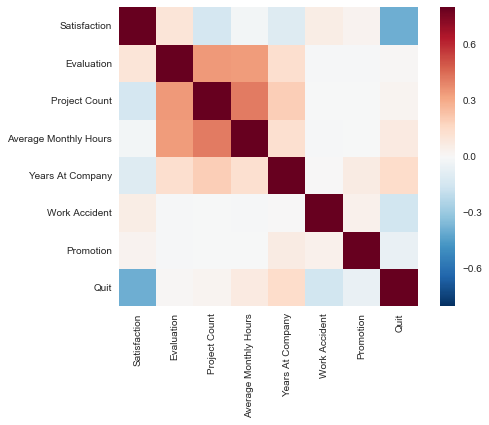

In [548]:
corrmat = df.corr()

# Create a heatmap to show correlations
sns.heatmap(corrmat, vmax = 0.8, square = True)
plt.show()

    From the heatmap, I want to exclude 'Work Accident' and 'Promotion'
    And since the direction requires only 2 categorical variable, I decided to work with 'Department' and 'Salary'

Targeted Variable is 'Quit'

    Direction: Require 1 to 2 Categorical Variable and 3 to 4 Continous Variables
    Continous Variable: Satisfaction, Evaluation, Average Monthly Hours
    Categorical Variable: Department, Salary

In [549]:
# Create a dataframe with the variables I want to work with
df_data = df[['Satisfaction', 'Evaluation', 'Average Monthly Hours', 'Department', 'Salary', 'Quit']]
print(df_data.head())
print(df_data['Department'].unique())

   Satisfaction  Evaluation  Average Monthly Hours Department  Salary  Quit
0          0.38        0.53                  157.0      sales     low     1
1          0.80        0.86                  262.0      sales  medium     1
2          0.11        0.88                  272.0      sales  medium     1
3          0.72        0.87                  223.0      sales     low     1
4          0.37        0.52                  159.0      sales     low     1
['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


Label meaning:
    * RandD = Research and Development
    * product_mng = Product Manager
    * hr = Human Resources

# Starts finding Features

In [574]:
# Create a dataframe for features
features = pd.get_dummies(df_data['Department'])

# Create a column for managers
features['Managers'] = np.where((df_data['Department'].isin(['management', 'product_mng'])), 1, 0)
features.head()

print(pd.crosstab(features['Managers'], df_data['Department']))

Department    IT  RandD  accounting   hr  management  marketing  product_mng  \
Managers                                                                       
0           1227    787         767  739           0        858            0   
1              0      0           0    0         630          0          902   

Department  sales  support  technical  
Managers                               
0            4140     2229       2720  
1               0        0          0  


    Managers tend to have better income in the company. 
    This variable is for future calculation for:
        * high income and hours worked or satisfaction level

In [575]:
# Create a column for satisfied employees (categorical)
## 0.7 is a threshold, need to describe i
## better to not hard code
features['Satisfied'] = np.where(df_data['Satisfaction'] > 0.7, 1, 0)
print(df_data['Satisfaction'].groupby(features['Satisfied']).describe())

            count      mean       std   min   25%   50%   75%  max
Satisfied                                                         
0          8701.0  0.444052  0.183480  0.09  0.36  0.48  0.59  0.7
1          6298.0  0.846013  0.083537  0.71  0.77  0.84  0.91  1.0


In [576]:
df_data.head()

,Satisfaction,Evaluation,Average Monthly Hours,Department,Salary,Quit
0,0.38,0.53,157.0,sales,low,1
1,0.80,0.86,262.0,sales,medium,1
2,0.11,0.88,272.0,sales,medium,1
3,0.72,0.87,223.0,sales,low,1
4,0.37,0.52,159.0,sales,low,1


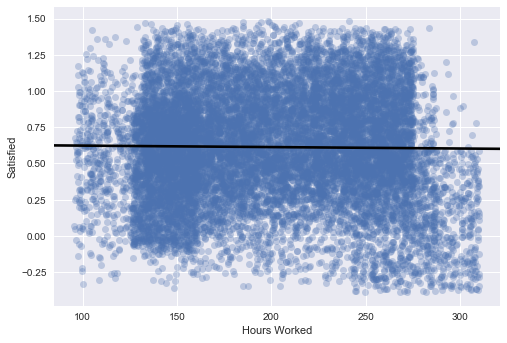

In [577]:
# Create a feature that represent the satisfied employees (continous)
features['Efficient'] = df_data['Satisfaction']

sns.regplot(
    df_data['Average Monthly Hours'],
    features['Efficient'],
    x_jitter=.49,
    y_jitter=.49,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.xlabel('Hours Worked')
plt.ylabel('Satisfied')
plt.show()

    not correlated

    This feature is to find the employees who are satisfied with their jobs
        * could be used to determine the relationships between income and hours

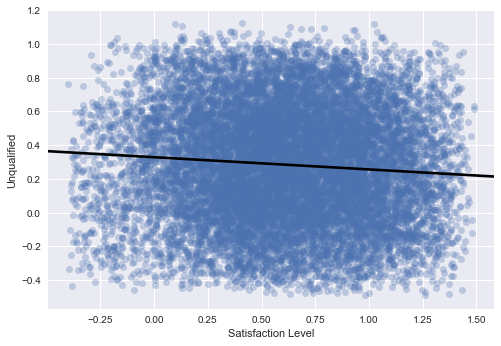

In [578]:
# Reverse-coding the 'Evaluation' variable so that higher scores mean less qualified
# (and thus possibly not qualified).

## should be normalize
features['Inept'] = max(df_data['Evaluation']) - df_data['Evaluation']

sns.regplot(
    df_data['Satisfaction'],
    features['Inept'],
    x_jitter=.49,
    y_jitter=.49,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.xlabel('Satisfaction Level')
plt.ylabel('Unqualified')
plt.show()

    This feature determines the unqualifed workers and their satisfaction level
        * you can see a trend of workers who are unqualifed tend to be more unsatisfied

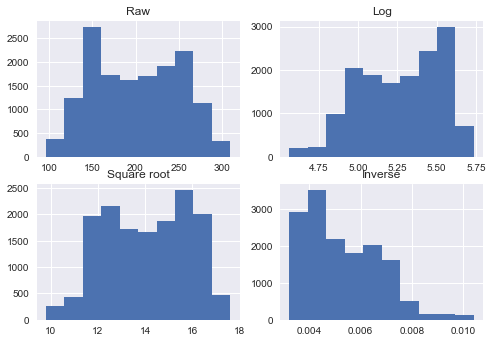

In [579]:
# Making a four-panel plot.
fig = plt.figure()

fig.add_subplot(221)
plt.hist(df_data['Average Monthly Hours'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df_data['Average Monthly Hours'].dropna()))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(df_data['Average Monthly Hours'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/df_data['Average Monthly Hours'].dropna())
plt.title('Inverse')
plt.show()

# make a feature from the Raw one.
features['Monthly Hours'] = df_data['Average Monthly Hours']

    This feature demonstrates the Average Monthly Hours for all the workers
        * I decided to go with the raw data because it will be easier to understand

In [580]:
# Create a better indicator for Income,
# Currently it is coded 1 for yes and 2 for no
features['Low Income'] = np.where(((df_data['Salary'] == 'low')), 1, 0)
features['Stable Income'] = np.where(((df_data['Salary'] == 'medium') |
                                      (df_data['Salary'] == 'high')), 1, 0)

    These two features represent the workers with low income and stable income (medium + high)
 

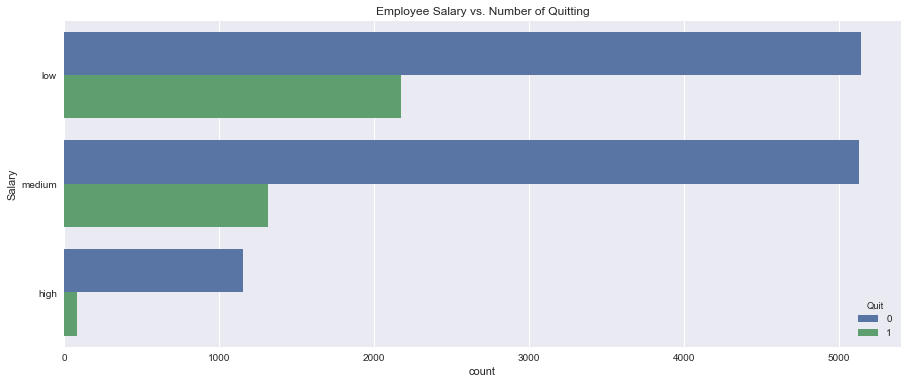

In [581]:
# Plot a graph that shows the Quitting Rate and Salary
# Setting the overall aesthetic.

## better with pie chart.
sns.set(style = 'darkgrid')

# Quit coded 1 = yes, coded 0 = no
ax = plt.subplots(figsize=(15, 6))
ax = sns.countplot(y = 'Salary', hue = 'Quit', data = df_data)
ax.set_title('Employee Salary vs. Number of Quitting')
plt.show()

In [582]:
print('Proportion of People with Low Income who Quit:', "{0:.4f}".format(
      len(df_data[(df_data['Salary'] == 'low') & (df_data['Quit'] == 1)]) /
      len(df_data[(df_data['Salary'] == 'low')])))
print('Proportion of People with Medium Income who Quit:', "{0:.4f}".format(
      len(df_data[(df_data['Salary'] == 'medium') & (df_data['Quit'] == 1)]) /
      len(df_data[(df_data['Salary'] == 'medium')])))
print('Proportion of People with High Income who Quit:', "{0:.4f}".format(
      len(df_data[(df_data['Salary'] == 'high') & (df_data['Quit'] == 1)]) /
      len(df_data[(df_data['Salary'] == 'high')])))

Proportion of People with Low Income who Quit: 0.2969
Proportion of People with Medium Income who Quit: 0.2043
Proportion of People with High Income who Quit: 0.0663


    As you can see, the employees with lower income has a higher quitting rate

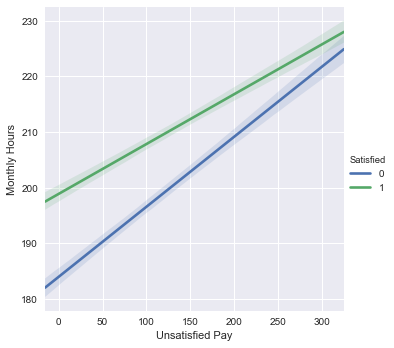

In [583]:
# Create the interaction of unsatisfied Pay
features['Unsatisfied Pay'] = features['Monthly Hours'] * features['Low Income']

# A plot of an interaction.
# People with unsatisfied income and how much they tend to work monthly
sns.lmplot(
    x='Unsatisfied Pay',
    y='Monthly Hours',
    hue='Satisfied',
    data = features,
    scatter = False
)
plt.show()

    This feature shows the employees with Unsatsified Pay (low income + high hours)

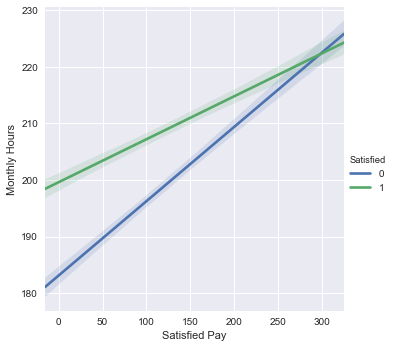

In [559]:
# Create the interaction of satisfied Pay
features['Satisfied Pay'] = features['Monthly Hours'] * features['Stable Income']

# A plot of an interaction.
# People with satisfied income and how much they tend to work monthly
sns.lmplot(
    x='Satisfied Pay',
    y='Monthly Hours',
    hue='Satisfied',
    data = features,
    scatter = False
)
plt.show()

        This feature shows the employees with Satsified Pay (low income + high hours)
The two graphs about Work Hours and Satisfaction are similart, employees who worked long hours tend to be unsatisfied with their job

In [584]:
# Create a feature with unsatisfied managers
features['Unsat Managers'] = features['Managers'] * features['Satisfied']
print(df_data['Satisfaction'].groupby(features['Unsat Managers']).describe())

                  count      mean       std   min   25%   50%   75%  max
Unsat Managers                                                          
0               14345.0  0.602567  0.248819  0.09  0.43  0.63  0.81  1.0
1                 654.0  0.838028  0.082170  0.71  0.77  0.83  0.90  1.0


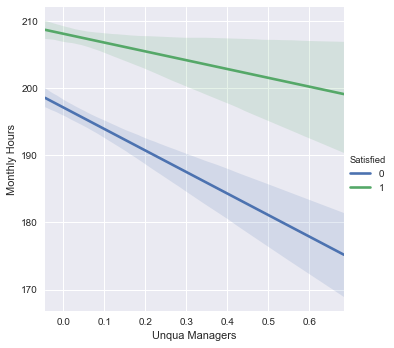

In [585]:
# Create a feature for unqualifed managers
features['Unqua Managers'] = features['Managers'] * features['Inept']

sns.lmplot(
    x='Unqua Managers',
    y='Monthly Hours',
    hue='Satisfied',
    data = features,
    scatter = False
)
plt.show()

In [586]:
# Drop the department variables since they are useless
features = features.drop(features.loc[:,'IT':'technical'], axis = 1)

In [587]:
# Add 'Quit' to features (targeted variable)
features['Quit'] = df_data['Quit']

# want features to be unrelated to each other

In [590]:
df_data.head()

,Satisfaction,Evaluation,Average Monthly Hours,Department,Salary,Quit
0,0.38,0.53,157.0,sales,low,1
1,0.80,0.86,262.0,sales,medium,1
2,0.11,0.88,272.0,sales,medium,1
3,0.72,0.87,223.0,sales,low,1
4,0.37,0.52,159.0,sales,low,1


    ## possible features
    ratio variables (ex: satisfaction and avg monthly hours, mean)
    combination of department and salary - see if they are more likely to quit or not
    
    ## can have a lot of features at first, and then get rid of them later on with selection process

In [589]:
features.head()

,Managers,Satisfied,Efficient,Inept,Monthly Hours,Low Income,Stable Income,Unsatisfied Pay,Unsat Managers,Unqua Managers,Quit
0,0,0,0.38,0.47,157.0,1,0,157.0,0,0.0,1
1,0,1,0.80,0.14,262.0,0,1,0.0,0,0.0,1
2,0,0,0.11,0.12,272.0,0,1,0.0,0,0.0,1
3,0,1,0.72,0.13,223.0,1,0,223.0,0,0.0,1
4,0,0,0.37,0.48,159.0,1,0,159.0,0,0.0,1


my goal here is to use the wrapper method, dropping each feature as I go. Since I want to use this dataset to figure out why employees are quitting their jobs, so the fitting features in this problem should be focusing on the negative side.
    ## The five features I want to keep:
    * Satisfied - this categorical variable shows me who is satisfied and who is unsatisfied
    * Inept - this variable shows me which employees are inefficient at their jobs
    * Low Income - I believe this is the main reason for people choosing to quit their jobs
    * Monthly Hours - determines the number of hours people worked monthly
    * Unsatisfied Pay - People with low income who work high hours tend to be unsatisfied
